In [425]:
import pandas as pd
import imageio as iio
import matplotlib.pyplot as plt
import numpy as np
import itertools

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
import os
from scipy import optimize
import scipy.linalg


from DLITE import cell_describe
#import matplotlib.pyplot as plt
%matplotlib inline



In [153]:
def extract_edges_verts(data):
    data_internal=data[data['branch-type']==2] #do we also need to split out sub skeletons for disconnected traces? We also want to identify holes by number of cycles compared to Nc, if cycles < Nc then there is a hole and can't get matrices.
    data_int=data_internal.drop_duplicates().reset_index(drop=True)
    
    #find unique vertices
    src=data_int[['node-id-src', 'image-coord-src-0', 'image-coord-src-1']].drop_duplicates()
    dst=data_int[['node-id-dst', 'image-coord-dst-0', 'image-coord-dst-1']].drop_duplicates()

    src=src.rename(columns={'node-id-src':'node_id', 'image-coord-src-0':'y', 'image-coord-src-1':'x'})
    dst=dst.rename(columns={'node-id-dst':'node_id', 'image-coord-dst-0':'y', 'image-coord-dst-1':'x'})

    node_coords=pd.concat([src,dst]).drop_duplicates().reset_index(drop=True)
    nodes=np.array(sorted(node_coords['node_id']))
   
    #edges as vertex pairs
    edge_verts=np.array(data_int[['node-id-src', 'node-id-dst']])
    edge_rad=np.array(data_int.edge_rad)
    
    #re index nodes
    new_nodes=np.linspace(0,len(node_coords)-1, len(node_coords)).astype(int)
    node_map = {nodes[i]: new_nodes[i] for i in range(len(new_nodes))}
    node_coords['node_id']=[node_map[x] for x in node_coords['node_id']]
    n_coords=np.array(node_coords.sort_values(by=['node_id']).iloc[:,1:]) #image coordinates of nodes
    
    #use map to reindex list of verices connected to an edge

    edge_verts[:,0]=[node_map[x] for x in edge_verts[:,0]]
    edge_verts[:,1]=[node_map[x] for x in edge_verts[:,1]]

    #edge_verts[data_int[data_int['cross']<0].index.values]=edge_verts[data_int[data_int['cross']<0].index.values][:, ::-1]
    
    return edge_verts, n_coords, edge_rad, data_int.xc, data_int.yc

In [148]:
def construct_ev_incidence_matrix(edge_verts, Ne, Nv):
    #Find the edge-vetex incidence matrix A_jk

    A=np.zeros((Ne,Nv))
    max_v=np.max(edge_verts, axis=1)
    min_v=np.min(edge_verts, axis=1)

    for j in range(0,Ne):
        A[j][max_v[j]]=1 #flows into vertex
        A[j][min_v[j]]=-1 #flows out of vertex
        
    return A

def construct_adjacency_matrix(A):
    Adj=np.dot(np.transpose(abs(A)),abs(A)) #create vertex-vertex adjacency matrix
    Adj[np.where(Adj>1)]=0
    Adj_sp=csr_matrix(Adj)
    G = nx.from_scipy_sparse_matrix(Adj_sp) #create networkx graph object from sparse adjacency matrix
    
    return G

def get_cycles(G, n_threshold):
       #For small graphs we can use the minimum_cycle_basis function below, but it is very very slow for most images:
    #cells=nx.minimum_cycle_basis(G)
    
    #in order to use simple_cycles function we must have a directed graph
    DG=nx.to_directed(G) #transform to symmetric directed graph
    cycles=[x for x in list(nx.simple_cycles(DG)) if len(x)>2 ] #find simple cycles upto length 12 edges and remove links interoduced by directed graph
    #remove duplicates
    cycles.sort()
    c=sorted(list(cycles for cycles,_ in itertools.groupby(cycles)), key=len) 
    cells=[c[0]]
    for i in c:
         if all([len(set(i).intersection(x))<3 for x in cells]):
                cells.append(i)
    
    return cells

def assign_edges_to_cells(cells, edge_verts, Ne):
    #edge indexs in each cell.
    cell_edges={}
    for i in range(len(cells)):
        for j in range(Ne):
            if(set(edge_verts[j]).issubset(cells[i])):
                if i in cell_edges.keys():
                    cell_edges[i]=list(set(cell_edges[i]).union([j]))
                else:
                    cell_edges[i]=[j]
    return cell_edges

def get_edge_cells(cells, edge_verts,Ne):
    #get edges connected to each cell, 1 for peripheral edges, 2 for other edges
    edge_cells={}
    for i in range(len(cells)):
        for j in range(Ne):
            if(set(edge_verts[j]).issubset(cells[i])):
                if j in edge_cells.keys():
                    edge_cells[j]=list(set(edge_cells[j]).union([i]))
                else:
                    edge_cells[j]=[i]
    return edge_cells

def construct_ce_incidence_matrix(cells,edge_verts,cell_edges, Nc, Ne, R):  
    B=np.zeros((Nc,Ne))
    # for i in range(Nc):
    #     for j in range(len(cell_edges[i])):
    #         ind=np.where(cells[i]==edge_verts[list(cell_edges[i])][j,0])[0][0] #find where first element in edge in cell
    #         if cells[i][ind - 1]==edge_verts[list(cell_edges[i])][j,1]: #if previous vertex = other edge in cell -> anti clock wise
    #             B[i, list(cell_edges[i])[j]]=-1
    #         else:
    #             B[i,list(cell_edges[i])[j]]=1 #clockwise

    for i in range(0,Nc): #loop over cells
        edge_cell = cell_edges[i] #get edge ids connected to each cell (cells is a dictionary)
        no_sides = len(edge_cell) 
        edge_cell=np.array(edge_cell).astype(int)
        edge_vert_id=edge_verts[edge_cell]


        #get vertex positions from ids
        coord_verts=R[np.unique(edge_vert_id)]
        
        Ralpha=coord_verts-np.mean(coord_verts, axis=0) # vertex coordinates in frame of reference of cell
        ang=np.arctan2(Ralpha[:,1], Ralpha[:,0])%(2*np.pi) #angle wrt to +ve horizontal x-axis
        
        gs=np.transpose(np.vstack((np.unique(edge_vert_id), ang))) #get unique edges and combine with angle
        gs=gs[np.argsort(-gs[:,1], axis=0)] #order vertex ids by clockwise angle from theta=0

        max_ev = np.max(edge_vert_id, axis=1)
        min_ev = np.min(edge_vert_id, axis=1)
        
        #for each edge find the location of the min and max vertex if the min vertex is 1 before the 
        # max vertex in the ordered list then the edge is going clockwise round the cell,
        #if not then it is going anti clockwise
        for j in range(0,no_sides):
            
            a=np.where(gs[:,0].astype(int)==max_ev[j])[0][0]
            b=np.where(gs[:,0].astype(int)==min_ev[j])[0][0]      
            
            if a-b==1 or a-b == -(no_sides-1):
                B[i,int(edge_cell[j])] = 1 #clockwise
            else:
                B[i,int(edge_cell[j])] = -1 #anticlockwise
    return B

def get_interior_cells(cells, edge_cells, cell_edges, edge_verts, n_coords):
    b_cells=[edge_cells[edge][0] for edge in edge_cells if len(edge_cells[edge])==1] #boundary cells
    l_cells=np.linspace(0, len(cells)-1,len(cells) ).astype(int)
    
    interior_cells=[cells[i] for i in l_cells if i not in set(b_cells)]
    interior_cell_edges=[cell_edges[i]for i in l_cells if i not in set(b_cells)]
    
    int_vertices=np.unique([x for sublist in interior_cells for x in sublist])
    int_edges=np.unique([x for sublist in interior_cell_edges for x in sublist])
    
    int_edge_verts=edge_verts[sorted(int_edges)]
    int_n_coords=n_coords[sorted(int_vertices)]

    #re index  and edges
    nodes=sorted(int_vertices)
    new_nodes=np.linspace(0,len(int_vertices)-1, len(int_vertices)).astype(int)
    node_map = {nodes[i]: new_nodes[i] for i in range(len(new_nodes))}
    
    edges=sorted(int_edges)
    new_edges=np.linspace(0,len(int_edges)-1, len(int_edges)).astype(int)
    edge_map = {edges[i]: new_edges[i] for i in range(len(new_edges))}


    int_edge_verts[:,0]=[node_map[x] for x in int_edge_verts[:,0]]
    int_edge_verts[:,1]=[node_map[x] for x in int_edge_verts[:,1]]

    int_cells=[[node_map[x] for x in sublist]for sublist in interior_cells]
    int_cell_edges=[[edge_map[x] for x in sublist]for sublist in interior_cell_edges]
    
    return int_cells,int_cell_edges, int_edge_verts, int_n_coords


In [401]:
data=pd.read_csv("DLITE_test_data_fr001.csv")
data.loc[data.dist_mid>data.edge_rad, 'edge_rad']= data[data.dist_mid>data.edge_rad].dist_mid - data[data.dist_mid>data.edge_rad].edge_rad +50

In [402]:
edge_verts, n_coords, edge_rad, xc, yc=extract_edges_verts(data)
Ne=len(edge_verts)
Nv=len(n_coords)
n_coords=n_coords[:,::-1]

In [403]:
rc=np.array([xc,yc]).T
r1=n_coords[edge_verts[:,0]]
r2=n_coords[edge_verts[:,1]]

edge_verts[np.where(np.cross(r1-rc, r2-rc)>0)]=edge_verts[np.where(np.cross(r1-rc, r2-rc)>0)][:,::-1]
nodes=[cell_describe.node(x) for x in n_coords]
edges=[cell_describe.edge(nodes[edge_verts[x,0]], nodes[edge_verts[x, 1]], edge_rad[x]) for x in range(len(edge_verts))]

In [404]:
A=construct_ev_incidence_matrix(edge_verts, Ne, Nv)
G=construct_adjacency_matrix(A)
cell_verts=nx.minimum_cycle_basis(G)
Nc=len(cell_verts)
for i in range(Nc):
    points=n_coords[cell_verts[i]]

    cc=np.mean(points, axis=0)

    angles=np.arctan2((points-cc)[:,1],(points-cc)[:,0]) 

    indexlist = sorted(range(len(angles)), key=angles.__getitem__)

    cell_verts[i]=np.array(cell_verts[i])[indexlist]

cell_edges=assign_edges_to_cells(cell_verts, edge_verts, Ne)




In [405]:
cells=[cell_describe.cell([nodes[k] for k in cell_verts[x]], [edges[j] for j in cell_edges[x]]) for x in range(Nc)]

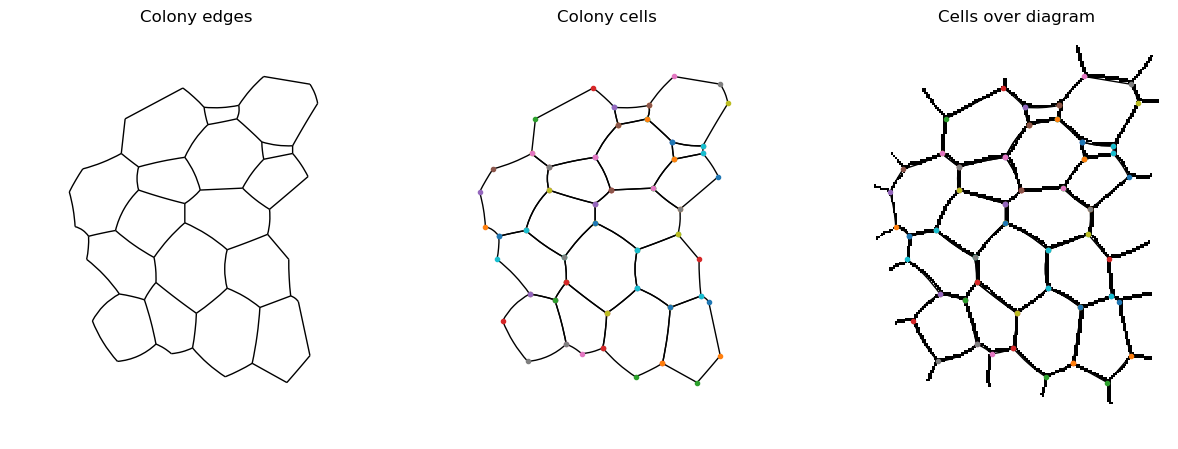

In [406]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

## All edges
axes[0].set_title("Colony edges")
for edge in edges:
    edge.plot(axes[0])

## Just the cells
axes[1].set_title("Colony cells")
for cell in cells:
    cell.plot(axes[1])

## With original image
axes[2].set_title("Cells over diagram")
img = iio.v2.imread('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\DLITE_Test\\Frames/traces/ruffle_11_fr001_trace.tif')
axes[2].imshow(img, cmap='Greys')
for cell in cells:
    cell.plot(axes[2])

## Formatting   
for ax in axes:
    ax.set(xlim=(0,img.shape[1]), ylim=(img.shape[0], 0), aspect=1)
    ax.axis('off')

In [407]:
this_colony = cell_describe.colony(cells, edges, nodes)

guess tension is [0.62, 0.93, 0.23, 0.07, 0.9, 0.72, 0.54, 0.21, 0.84, 0.33, 0.44, 0.96, 0.67, 0.19, 0.44, 0.12, 0.99, 0.45, 0.68, 0.96, 0.21, 0.07, 0.68, 0.38, 0.7, 0.76, 0.79, 0.94, 0.91, 0.76, 0.4, 0.04, 0.45, 0.74, 0.43, 0.45, 0.23, 0.92, 0.04, 0.66, 0.93, 0.26, 0.76, 0.92, 0.77, 0.61, 0.41, 0.75, 0.97, 0.31, 0.15, 0.58, 0.05, 0.69, 0.39, 0.82, 0.06, 0.63, 0.01, 0.26, 0.88, 0.16, 0.42, 0.36, 0.3, 0.11]


Function value 0.7319510510421293
Solution [0.62       0.73354375 0.23       0.07       0.67897504 0.72580438
 0.50366661 0.53287253 0.40418626 0.75265921 0.64642687 0.50599652
 0.71413359 0.35284685 0.29760691 0.61849825 0.66058842 0.67690002
 0.46467136 0.69708922 0.72095928 0.66854215 0.56359897 0.60577555
 0.7        0.63326255 0.73175859 0.66092487 0.53711834 0.66801761
 0.87627642 0.04       0.66451465 0.75575392 0.57150738 0.66928857
 1.12452397 0.60557473 0.62250165 0.65067075 0.63341956 1.07746067
 0.62725758 0.86699866 0.36367568 0.37495496 0.5372875  0.69192349
 0.60898064 0.56410063 0.44367517 0.60630121 0.57745949 0.53985515
 0.84300533 0.82       0.5801868  0.63293779 0.01       0.77337604
 0.77337985 0.50547126 0.52954441 0.36       0.49098889 0.64164316]


-----------------------------


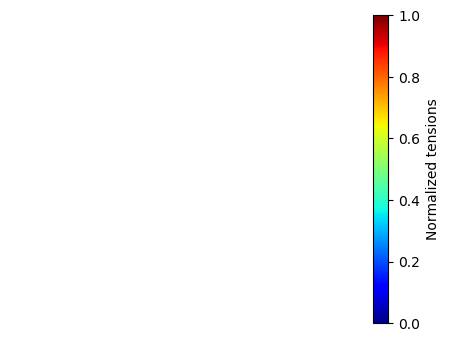

In [450]:
tensions, _, _ = this_colony.calculate_tension(solver='DLITE')
fig, ax = plt.subplots(1, 1, figsize=(6,4))

this_colony.plot_tensions(ax, 
                          fig, 
                          tensions, 
                          min_y=np.min(n_coords[:,1])-10, max_y=np.max(n_coords[:,1])+10, 
                          min_x=np.min(n_coords[:,0])-10, max_x=np.max(n_coords[:,0])+10, 
                          min_ten = 0, max_ten = 1, 
                          specify_color = 'jet', cbar = 'no', lw = 3)
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cl = plt.colorbar(sm, ax=ax)
cl.set_label('Normalized tensions')
ax.axis('off');

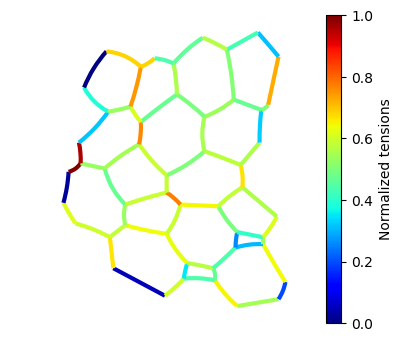

In [452]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

this_colony.plot_tensions(ax, 
                          fig, 
                          tensions, 
                          min_y=np.min(n_coords[:,1])-10, max_y=np.max(n_coords[:,1])+10, 
                          min_x=np.min(n_coords[:,0])-10, max_x=np.max(n_coords[:,0])+10, 
                          specify_color = 'jet', cbar = 'no', lw = 3)
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cl = plt.colorbar(sm, ax=ax)
cl.set_label('Normalized tensions')
ax.axis('off');

guess pressure is [0.016858777795451696, 0.0031296553391024435, 0.005631710513124318, 0.01327456166937548, 0.006349824970466685, 0.014764060485108796, 0.005207575018335581, 0.01054679976611335, 0.0055357560262671935, 0.004738299584311631, 0.008380112830537845, 0.012689899761727463, 0.012367827898309496, 0.02000054611108125, 0.01181649624221961, 0.00567386366544291, 0.007884983223712018]
Function value 0
Solution [0.01685878 0.00312966 0.00563171 0.01327456 0.00634982 0.01476406
 0.00520758 0.0105468  0.00553576 0.0047383  0.00838011 0.0126899
 0.01236783 0.02000055 0.0118165  0.00567386 0.00788498]


-----------------------------


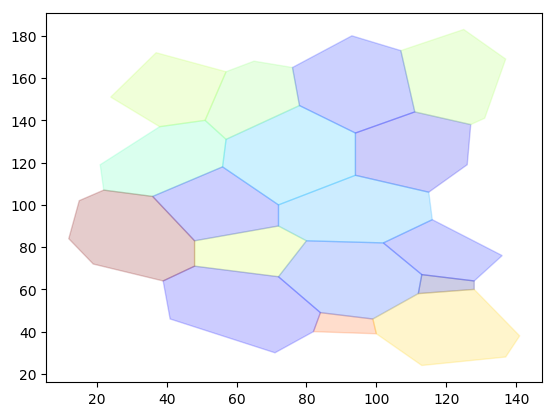

In [443]:
pressures, p_p, b_mat = this_colony.calculate_pressure(solver="DLITE")

this_colony.plot_pressures(ax, 
                          fig, 
                          pressures, 
                          specify_color = 'jet', cbar = 'no', lw = 3)
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=0.02))
sm._A = []
cl = plt.colorbar(sm, ax=ax)
cl.set_label('Normalized pressures')
ax.axis('off');

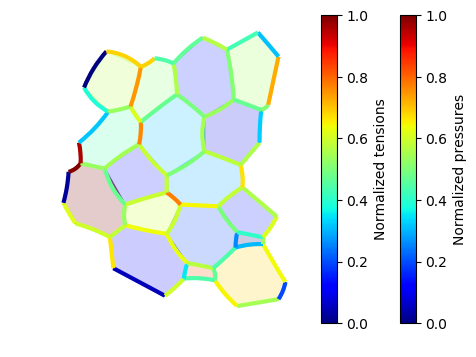

In [453]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))


this_colony.plot_pressures(ax, 
                          fig, 
                          pressures, 
                          specify_color = 'jet', cbar = 'no', lw = 3)
sm2 = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=1))
sm2._A = []
c2 = plt.colorbar(sm, ax=ax)
c2.set_label('Normalized pressures')

this_colony.plot_tensions(ax, 
                          fig, 
                          tensions,
                          min_y=np.min(n_coords[:,1])-10, max_y=np.max(n_coords[:,1])+10, 
                          min_x=np.min(n_coords[:,0])-10, max_x=np.max(n_coords[:,0])+10, 
                          specify_color = 'jet', cbar = 'no', lw = 3)
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cl = plt.colorbar(sm, ax=ax)
cl.set_label('Normalized tensions')


ax.axis('off');

In [420]:
a_mat = this_colony.make_tension_matrix(nodes, edges)
tensions, p = this_colony.solve_constrained_lsq(a_mat, 0, None)

In [437]:
a_mat.shape

(64, 66)

In [424]:
this_colony.solve_constrained_lsq(a_mat, 0, None)

(None,
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  1.        ],
        [ 0.        ,  1.        ,  0.        , ...,  0.        ,
          0.        ,  1.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  1.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         -0.50170686,  1.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.50170686,
          1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  0.        ]]))

In [440]:
  
        # Get N - number of columns
        n = np.shape(a_mat)[1]

        # Define matrix of ones
        p = np.ones((n + 1, n + 1))

        # Get A^TA
        a1 = np.dot(a_mat.T, a_mat)

        # Plug this into appropriate place in P 
        p[0:n, 0:n] = a1

        # Set last element in N,N position to 0 
        p[n, n] = 0


        t_or_p=0

        if t_or_p == 0:
            # Define Q
            q = np.zeros((n+1, 1))

            # Set last element to N (number of edges) 
            # Effectively says average value is 1
            q[n, 0] = n

        if t_or_p == 1:
            # Define Q
            q = np.zeros((n+1, 1))
            c = np.dot(a.T, b)
            c = c.reshape((len(c), ))

            if len(c) >= len(q[0:n,0]):
                q[0:n, 0] = c[0:n]
            else:
                q[0:len(c), 0] = c[0:len(c)]
            # Effectively says average is 0 
            q[n, 0] = 0

        # Solve PX = Q
        try:
            # By QR decomposition
            r1, r2 = scipy.linalg.qr(p)  # QR decomposition with qr function
            y = np.dot(r1.T, q)  # Let y=R1'.Q using matrix multiplication
            x = scipy.linalg.solve(r2, y)  # Solve Rx=y

            # By least squares - gives same result
            # x = scipy.linalg.lstsq(r2, y)

            # By LU decomposition - Both give same results        
            # L, U = scipy.linalg.lu_factor(p)
            # x = scipy.linalg.lu_solve((L, U), q)

        except np.linalg.LinAlgError as err:
            if 'Matrix is singular' in str(err):
                print("matrix is singular")
               
            else:
                print('Couldnt invert matrix')
                raise

        # return x[0:n][:, 0], p  # use this if solved using linalg.solve
        # # return x[0][0:N], P # use this if solved using linalg.lstsq


matrix is singular


In [441]:
x

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [ 0.],
       [ 0.],
       [ 0.]])

In [417]:
this_colony2 = cell_describe.colony(cells, edges, nodes)
tensions2, _, _ = this_colony2.calculate_tension(nodes=nodes, edges=edges,solver='KKT')


TypeError: 'NoneType' object is not subscriptable

In [418]:
this_colony2.calculate_pressure(solver='CellFit')

UnboundLocalError: local variable 'pressures' referenced before assignment

In [261]:

fig, ax = plt.subplots(1, 1, figsize=(6,4))

this_colony2.plot_tensions(ax, 
                          fig, 
                          tensions, 
                          min_y=np.min(n_coords[:,1])-10, max_y=np.max(n_coords[:,1])+10, 
                          min_x=np.min(n_coords[:,0])-10, max_x=np.max(n_coords[:,0])+10, 
                          min_ten = 0, max_ten = 1, 
                          specify_color = 'jet', cbar = 'no', lw = 3)
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cl = plt.colorbar(sm, ax=ax)
cl.set_label('Normalized tensions')
ax.axis('off');

TypeError: 'NoneType' object is not subscriptable

In [322]:
[e.radius for e in edges]

[64.57626578414374,
 261192.33543741796,
 25.599540317808593,
 83299.91955471641,
 21.280093719051823,
 93.1921502121337,
 47.43099680976236,
 59.844851892028714,
 87.2379155768227,
 64.76969268951285,
 215538.09323352046,
 15137.05701640441,
 30.99358143217719,
 80.18331329638714,
 25959.679728981308,
 136570.09637995614,
 113.72590384135431,
 96.67660695966305,
 193.869938845496,
 94.40141344481405,
 85.65270896128064,
 88.442950020175,
 67.82669631761607,
 20855.57838384586,
 35374.281921645794,
 85321.74514486651,
 79455.8545706287,
 34526.47578823316,
 65.18308077219982,
 175.18358320877792,
 219.59436876046428,
 55.76096008786949,
 84.48670400444446,
 67.67805736946521,
 108.69217703114624,
 63.51767509858809,
 521.4595166950305,
 46932.04793072765,
 24.80283469750063,
 163746.85043683302,
 3275470.417017496,
 56.70694238362832,
 1043.658929448667,
 38557.87832262733,
 76721.45265030638,
 271.7699486404396,
 65.26823575368853,
 36.941872297807436,
 44.67037154194489,
 76186.84718

In [325]:
mean=np.mean(tensions)
sd=np.std(tensions)

In [326]:
bad_tensions = [x for x in tensions if (x < mean - 3 * sd) or (x > mean + 3 * sd)]

In [327]:
bad_tensions

[0.04]

In [350]:
edges[8].radius

5.6097722286464435